# Q4

The data files that you received contain monthly excess returns for five industry portfolios and the market portfolio. Using monthly excess returns for the five industry portfolios and the market portfolio:

Calculate and report the Sharpe ratio and Treynor ratio for the five industry portfolios and the market portfolio.

Using market return as target return, calculate and report the information ratio and Sortino ratio for the five industry portfolios.

Briefly explain (in words) the economic significance of using the information ratio and Sortino ratio to measure the performance of well-diversified portfolios.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot, scatter, plot, axis
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

# Datetime
import datetime as dt
from datetime import datetime
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

In [2]:
Industry_Portfolio=pd.read_excel("Exam-Industry.xlsx",index_col=0)
Industry_Portfolio

,Cnsmr,Manuf,HiTec,Hlth,Other
Date,,,,,
190101,-1.34,4.20,3.01,-0.71,1.92
190102,2.89,4.87,3.45,3.33,2.63
190103,1.89,1.81,-0.83,2.29,-0.86
190104,4.36,2.58,3.16,6.37,1.11
190105,0.92,-2.55,-1.13,1.96,-2.40
...,...,...,...,...,...
190608,1.71,0.80,4.36,2.85,2.59
190609,-3.28,-2.84,-6.16,-6.01,-2.26
190610,8.63,6.01,6.74,2.25,7.25


In [3]:
Market_Portfolio=pd.read_excel("Exam–Market.xlsx",index_col=0)
Market_Portfolio

,Market
Date,
190101,1.99
190102,3.49
190103,0.46
190104,2.90
190105,-1.27
...,...
190608,2.91
190609,-4.37
190610,6.65


In [4]:
# Merge the excess return dataframe and the Market_Portfolio together

Merged_Portfolio = Industry_Portfolio.merge(Market_Portfolio,how='inner',left_index=True, right_index=True)
Merged_Portfolio 

,Cnsmr,Manuf,HiTec,Hlth,Other,Market
Date,,,,,,
190101,-1.34,4.20,3.01,-0.71,1.92,1.99
190102,2.89,4.87,3.45,3.33,2.63,3.49
190103,1.89,1.81,-0.83,2.29,-0.86,0.46
190104,4.36,2.58,3.16,6.37,1.11,2.90
190105,0.92,-2.55,-1.13,1.96,-2.40,-1.27
...,...,...,...,...,...,...
190608,1.71,0.80,4.36,2.85,2.59,2.91
190609,-3.28,-2.84,-6.16,-6.01,-2.26,-4.37
190610,8.63,6.01,6.74,2.25,7.25,6.65


In [5]:
# Deduct market portfolio from Industry_Portfolio

Deviation_from_target_df = pd.DataFrame(index = Industry_Portfolio.index,
                                        columns= Industry_Portfolio.columns)

for i in Industry_Portfolio.columns:
    Deviation_from_target_df[str(i)] = Industry_Portfolio[i].subtract(Market_Portfolio["Market"], fill_value=0)

In [6]:
# Initialize the Market_model DataFrame with appropriate indices and columns
Market_model=pd.DataFrame(index=["Jensen Alpha","CAPM beta"],
                          columns=Industry_Portfolio.columns)

# Loop through the first 10 columns of Merged_Portfolio (industry portfolios)
for column in range(Market_model.shape[1]):
    y = Merged_Portfolio.iloc[:, column]           # Dependent variable (industry portfolio excess return)
    x = Merged_Portfolio[["Market"]]                # Independent variables (Market excess return) # Check that it is "Rm-Rf"
    
    # Add a constant (intercept term) to the independent variables
    x = sm.add_constant(x)
    
    # Perform linear regression
    model = sm.OLS(y, x).fit()

    # Store the regression results in the Market_model DataFrame
    Market_model.iloc[0, column] = model.params['const']  # Intercept
    Market_model.iloc[1, column] = model.params['Market']  # Market (Rm-Rf)

In [7]:
Sharpe_df=pd.DataFrame(index=["Sharpe"],
                       columns=Industry_Portfolio.columns)

for column in range(Sharpe_df.shape[1]):
    Risk_Premium = Industry_Portfolio.iloc[:, column].mean()          
    Standard_Deviation = Industry_Portfolio.iloc[:, column].std() 
    Sharpe_ratio=Risk_Premium/Standard_Deviation
    Sharpe_df.iloc[0,column]=Sharpe_ratio
    
# Note: If Information ratio target is rf then it is the same as Sharpe ratio

In [8]:
Sortino_df=pd.DataFrame(index=["Sortino"],
                        columns=Industry_Portfolio.columns)

for column in range(Sortino_df.shape[1]):
    # Calculate Risk Premium (mean return)
    Risk_Premium = Industry_Portfolio.iloc[:, column].mean() 
    
    # Calculate downside risk relative to market
    Returns = Industry_Portfolio.iloc[:, column]  -  Merged_Portfolio["Market"]      # Extract the returns for the column
    downside_risk = np.where(Returns < 0, Returns ** 2, 0)  # Squared negative returns
    
    # Calculate Negative Standard Deviation (downside risk)
    Negative_Standard_Deviation = np.sqrt(np.mean(downside_risk))
    
    # Calculate Sortino Ratio
    if Negative_Standard_Deviation != 0:
        Sortino_ratio = Risk_Premium / Negative_Standard_Deviation     
    else:
        Sortino_ratio = None
    
    Sortino_df.iloc[0,column]=Sortino_ratio

In [9]:
Sortino_df

,Cnsmr,Manuf,HiTec,Hlth,Other
Sortino,1.300954,0.888959,2.056452,0.778428,1.121221


In [10]:
Treynor_df=pd.DataFrame(index=["Treynor"],
                        columns=Industry_Portfolio.columns)

for column in range(Treynor_df.shape[1]):
    column_name=Treynor_df.columns[column]
    Risk_Premium = Industry_Portfolio.iloc[:, column].mean()          
    Beta=Market_model.loc["CAPM beta",column_name]
    Treynor_ratio=Risk_Premium/Beta
    Treynor_df.iloc[0,column]=Treynor_ratio

In [11]:
Information_Ratio_df = pd.DataFrame({"Mean":Deviation_from_target_df.mean(),"Std":Deviation_from_target_df.std()})

In [12]:
Information_Ratio_df["Information Ratio"] = Information_Ratio_df["Mean"]/Information_Ratio_df["Std"]

In [13]:
Information_Ratio_df

,Mean,Std,Information Ratio
Cnsmr,0.054028,1.573212,0.034342
Manuf,-0.286250,1.593589,-0.179626
HiTec,0.277222,1.372218,0.202025
Hlth,0.056944,2.578849,0.022081
Other,-0.028750,1.786309,-0.016095


In [14]:
Performance_Measures=pd.concat([Sharpe_df,
                                Sortino_df,
                                Treynor_df,
                                Information_Ratio_df])

Performance_Measures=Performance_Measures.T

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


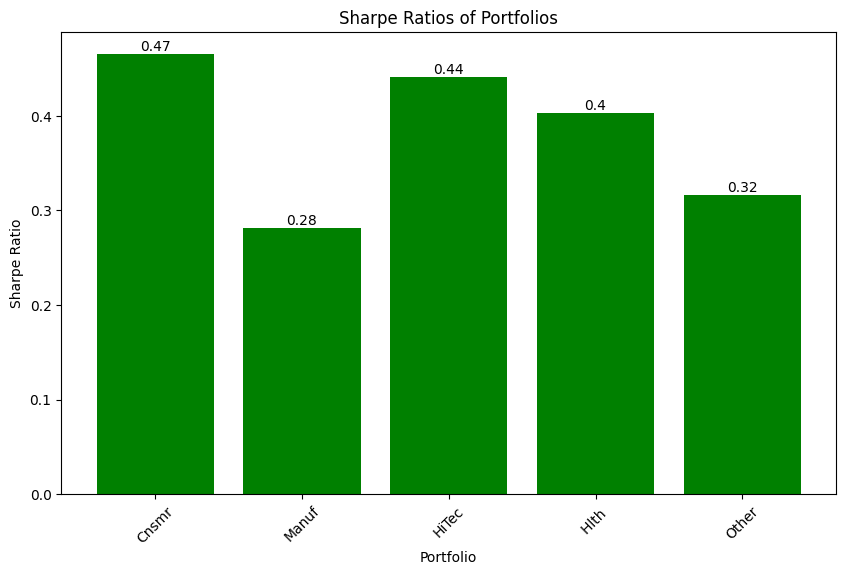

In [15]:
# Create a bar chart for the Sharpe ratios of each portfolio
plt.figure(figsize=(10,6))  
bars = plt.bar(Performance_Measures.index, Performance_Measures["Sharpe"], color='green')

plt.title("Sharpe Ratios of Portfolios")
plt.xlabel("Portfolio")
plt.ylabel("Sharpe Ratio")

# Add data labels
for bar in bars:
    yval = bar.get_height()  # Get the height of the bar
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.xticks(rotation=45)  
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


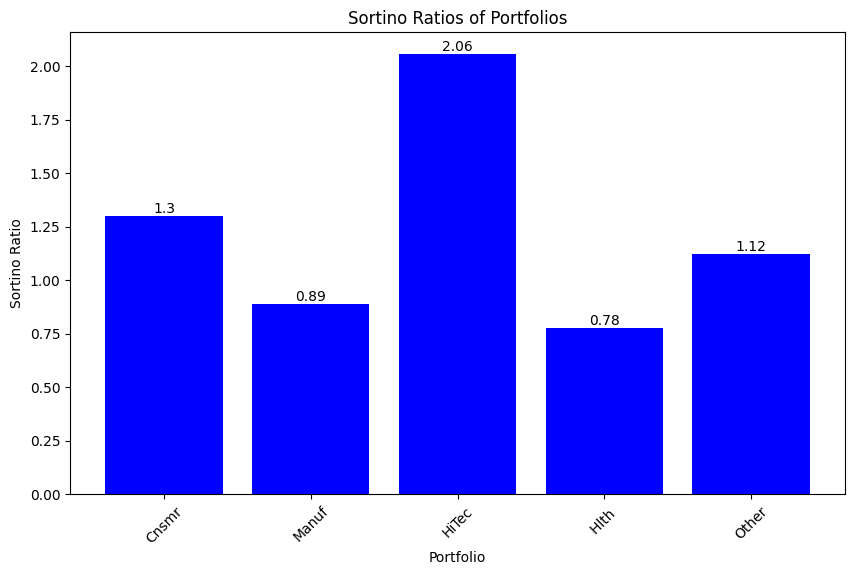

In [16]:
# Create a bar chart for the Sortino ratios of each portfolio
plt.figure(figsize=(10,6))  
bars = plt.bar(Performance_Measures.index, Performance_Measures["Sortino"], color='blue')

plt.title("Sortino Ratios of Portfolios")
plt.xlabel("Portfolio")
plt.ylabel("Sortino Ratio")

# Add data labels
for bar in bars:
    yval = bar.get_height()  # Get the height of the bar
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.xticks(rotation=45)  
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


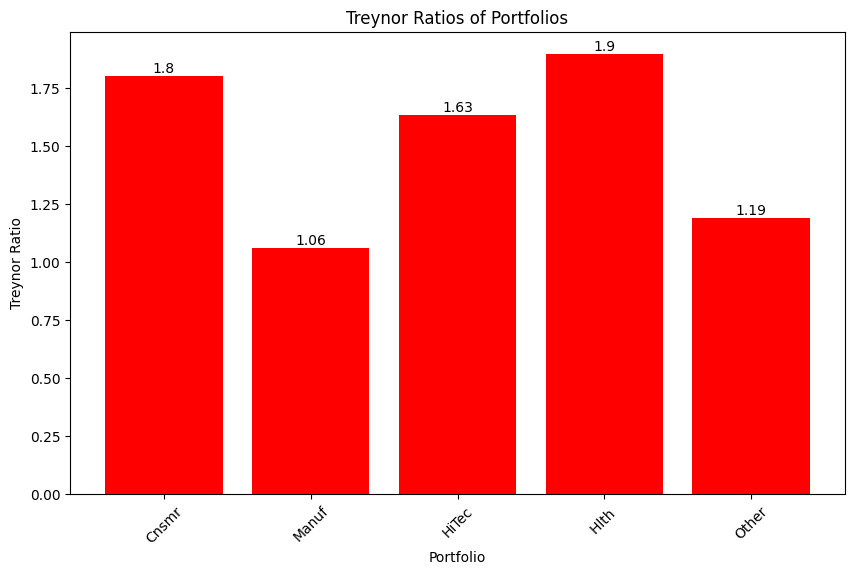

In [17]:
# Create a bar chart for the Treynor ratios of each portfolio
plt.figure(figsize=(10,6))  
bars = plt.bar(Performance_Measures.index, Performance_Measures["Treynor"], color='red')

plt.title("Treynor Ratios of Portfolios")
plt.xlabel("Portfolio")
plt.ylabel("Treynor Ratio")

# Add data labels
for bar in bars:
    yval = bar.get_height()  # Get the height of the bar
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.xticks(rotation=45)  
plt.show()

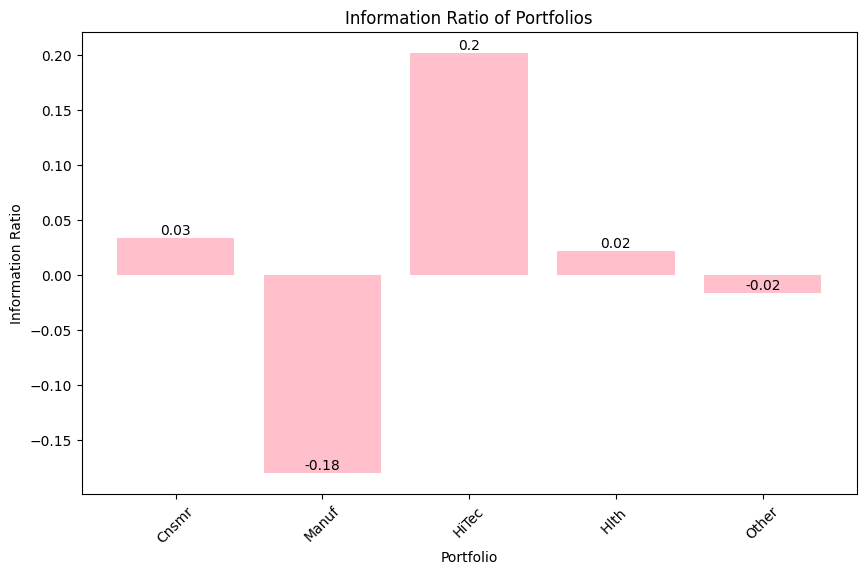

In [18]:
# Create a bar chart for the Information Ratio of each portfolio
plt.figure(figsize=(10,6))  
bars = plt.bar(Information_Ratio_df.index, Information_Ratio_df["Information Ratio"], color='pink')

plt.title("Information Ratio of Portfolios")
plt.xlabel("Portfolio")
plt.ylabel("Information Ratio")

# Add data labels
for bar in bars:
    yval = bar.get_height()  # Get the height of the bar
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.xticks(rotation=45)  
plt.show()

Briefly explain (in words) the economic significance of using the information ratio and Sortino ratio to measure the performance of well-diversified portfolios.

Information ratio is expected deviation from target (or benchmark) return, per unit of tracking error. It measures the ability of the fund manager to exceed target return, relative to the amount of tracking error. It is often used to evaluate fund managers who follow "enhanced indexing" strategy by overweighting or underweighting selected components of stock index. When comparing two fund managers, the manager with higher information ratio has the better ability to exceed target return for every unit of tracking error. In well diversified portfolios, the higher the Information ratio, the better the portfolio is performing.

Sortino ratio measures the portfolio's expected deviation from the benchmark return, per unit of below-target semi-deviation. Below-target semi-deviation only considers risk that realised return on investment falls below the target return. As below-target semi-variance is a measure of downside risk, Sortino ratio is able to distinguish between asymmetric distributions with same variance but different skewness. As investors are more sensitive to downside volatility compared with upside volatility, Sortino ratio maybe more informative compared to the Sharpe ratio, especially when the return distribution is not normal. Returns with the same variance but different skewness would have the same Sharpe Ratio but different Sortino ratio.  In well diversified portfolios, the higher the Sortino ratio, the better the portfolio is performing.